In [93]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KDTree
from sklearn.svm import SVR
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
import math
from sklearn.preprocessing import LabelEncoder


In [4]:
df = pd.read_csv("65d4f0fcb8af9_amex_campus_challenge_train_3.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12229978 entries, 0 to 12229977
Data columns (total 71 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   ind_recommended               int64  
 1   activation                    int64  
 2   customer_digital_activity_04  float64
 3   customer_spend_01             float64
 4   customer_industry_spend_01    float64
 5   customer_industry_spend_02    float64
 6   customer_industry_spend_03    float64
 7   customer_industry_spend_04    float64
 8   customer_industry_spend_05    float64
 9   customer_spend_02             float64
 10  customer_spend_03             float64
 11  customer_merchant_02          float64
 12  customer_merchant_01          float64
 13  customer_spend_04             float64
 14  customer_spend_05             float64
 15  customer_spend_06             float64
 16  customer_spend_07             float64
 17  merchant_spend_01             float64
 18  merchant_spend_02   

In [42]:
merchant_columns = [col for col in df.columns if col.startswith('merchant_')]
df_merchant = df[merchant_columns]


#### There are 3 columns of profile, will have to visualise for both

In [ ]:
df_merchant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12229978 entries, 0 to 12229977
Data columns (total 14 columns):
 #   Column               Dtype  
---  ------               -----  
 0   merchant_spend_01    float64
 1   merchant_spend_02    float64
 2   merchant_spend_03    float64
 3   merchant_spend_04    float64
 4   merchant_spend_05    float64
 5   merchant_spend_06    float64
 6   merchant_spend_07    float64
 7   merchant_spend_08    float64
 8   merchant_profile_01  float64
 9   merchant_spend_11    float64
 10  merchant_profile_02  float64
 11  merchant_spend_09    float64
 12  merchant_profile_03  float64
 13  merchant_spend_10    float64
dtypes: float64(14)
memory usage: 1.3 GB


#### Filling with mean values

In [43]:
df_merchant = df_merchant.fillna(df_merchant.mean()) 

In [ ]:

def display_profile_graph(merchant_profile: str):
    feature_columns = [col for col in df_merchant.columns if not col.startswith("merchant_profile")]
    n = len(feature_columns)
    nrows = int(np.ceil(n / 2))  
    ncols = 2  
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows * 5))  
    fig.tight_layout(pad=5.0)
    axs = axs.flatten()
    for i, col in enumerate(feature_columns):
        axs[i].scatter(df_merchant[col], df_merchant[merchant_profile])
        axs[i].set_xlabel(col)
        axs[i].set_ylabel(merchant_profile)
        axs[i].set_title(f'{col} vs. {merchant_profile}')
    for ax in axs[i+1:]:
        ax.set_visible(False)

    plt.show()


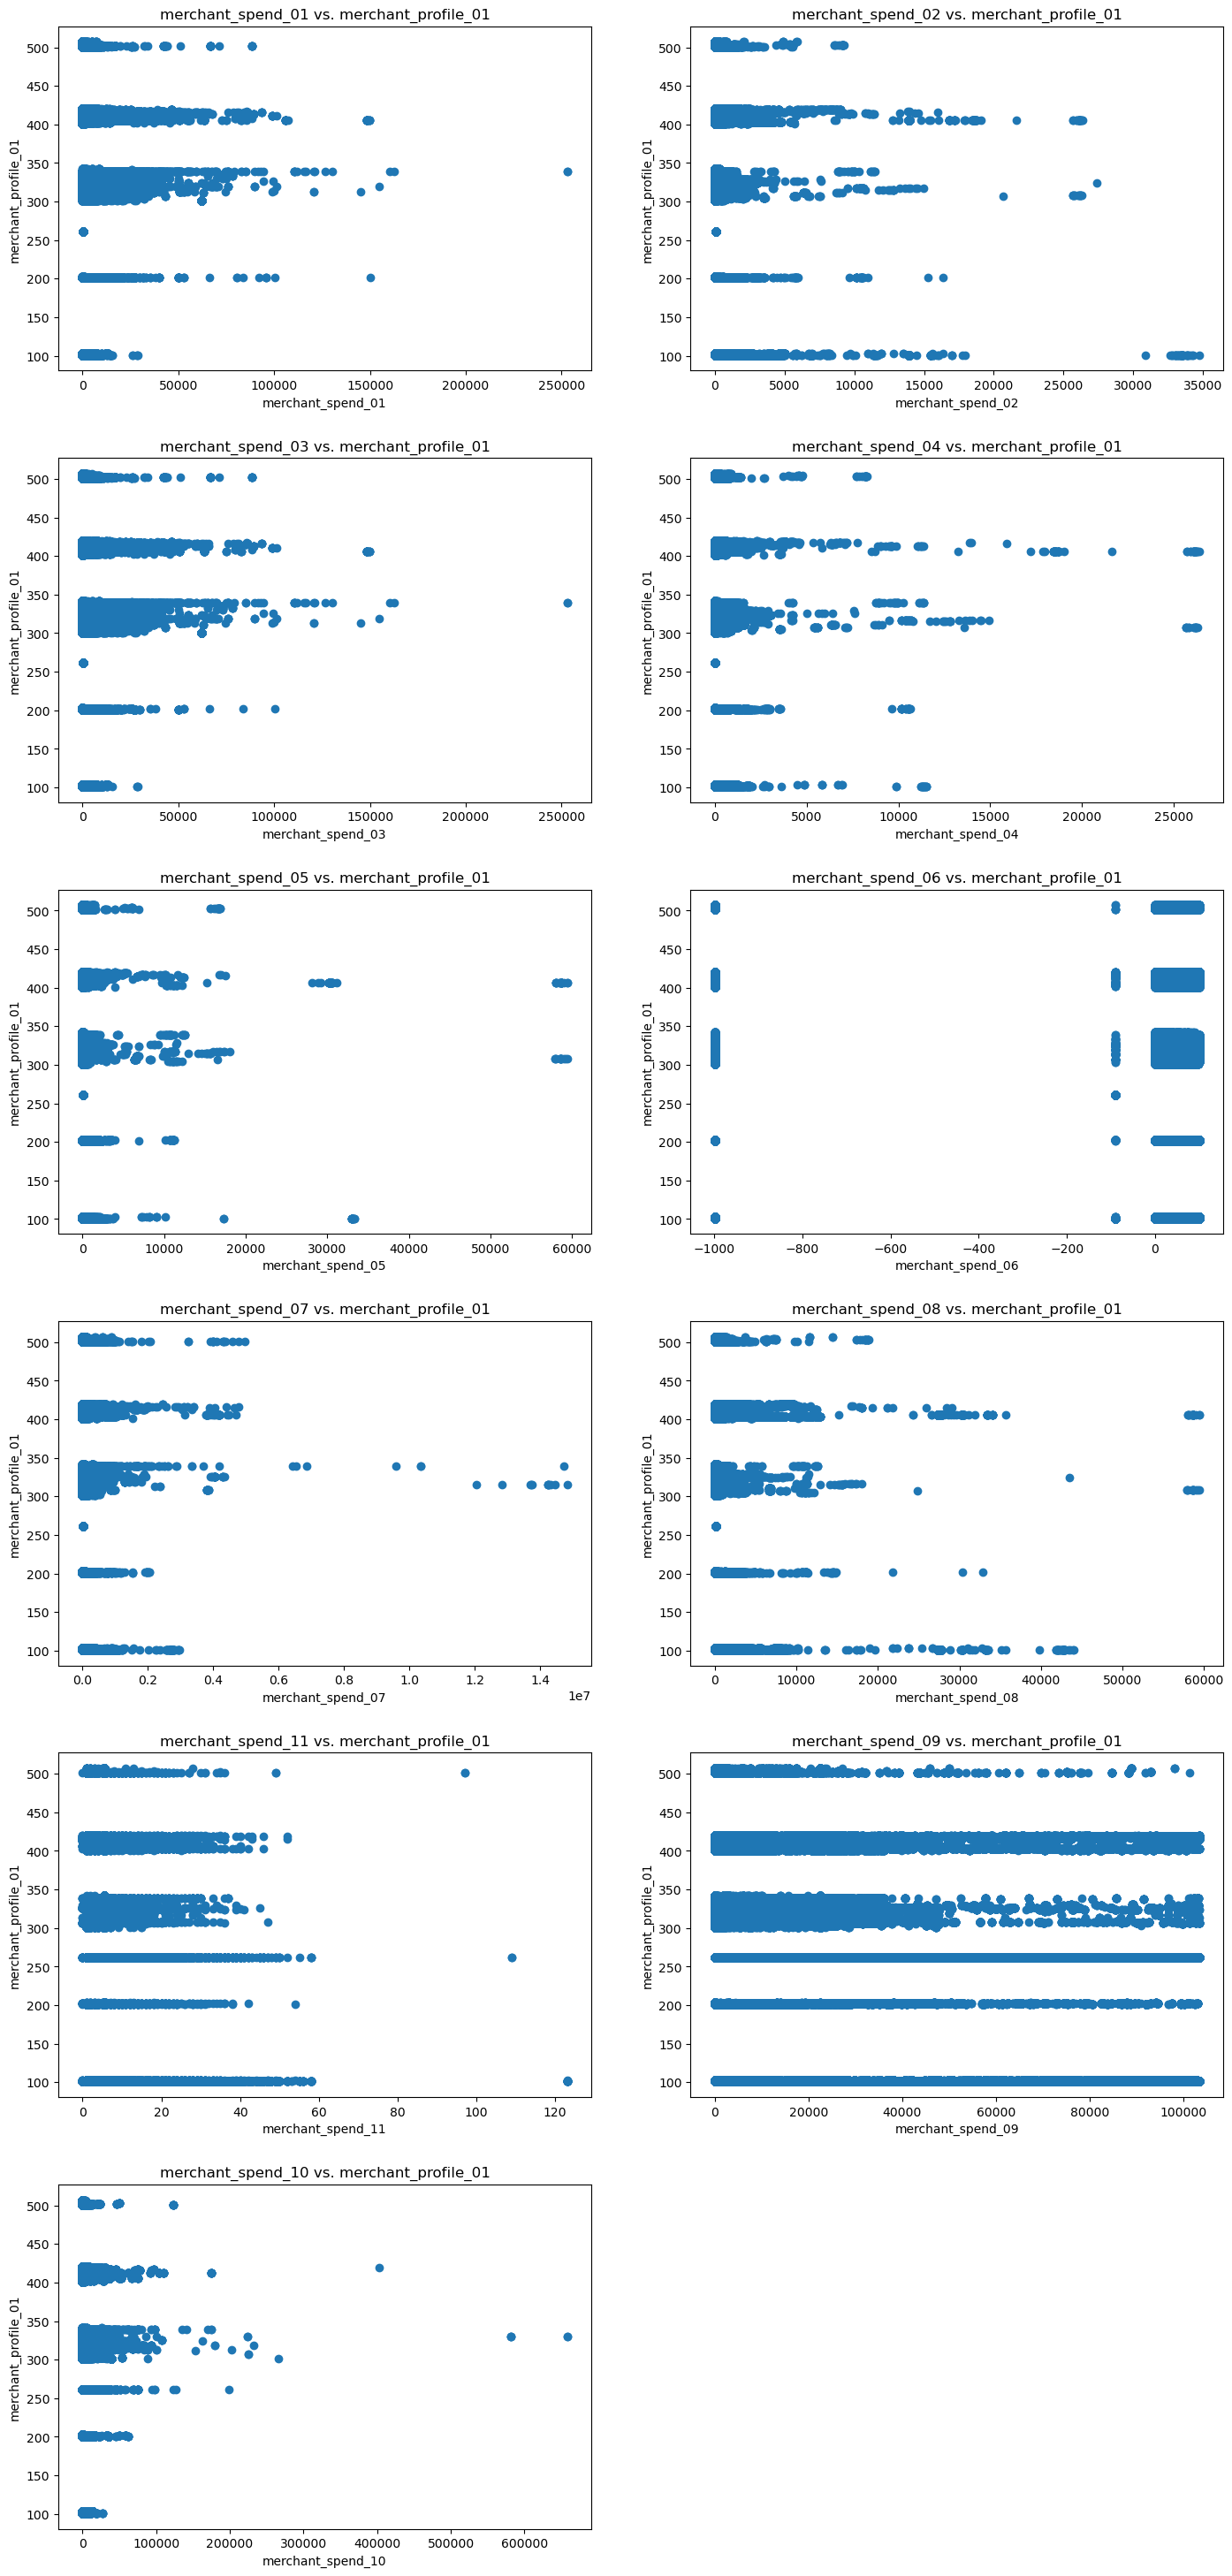

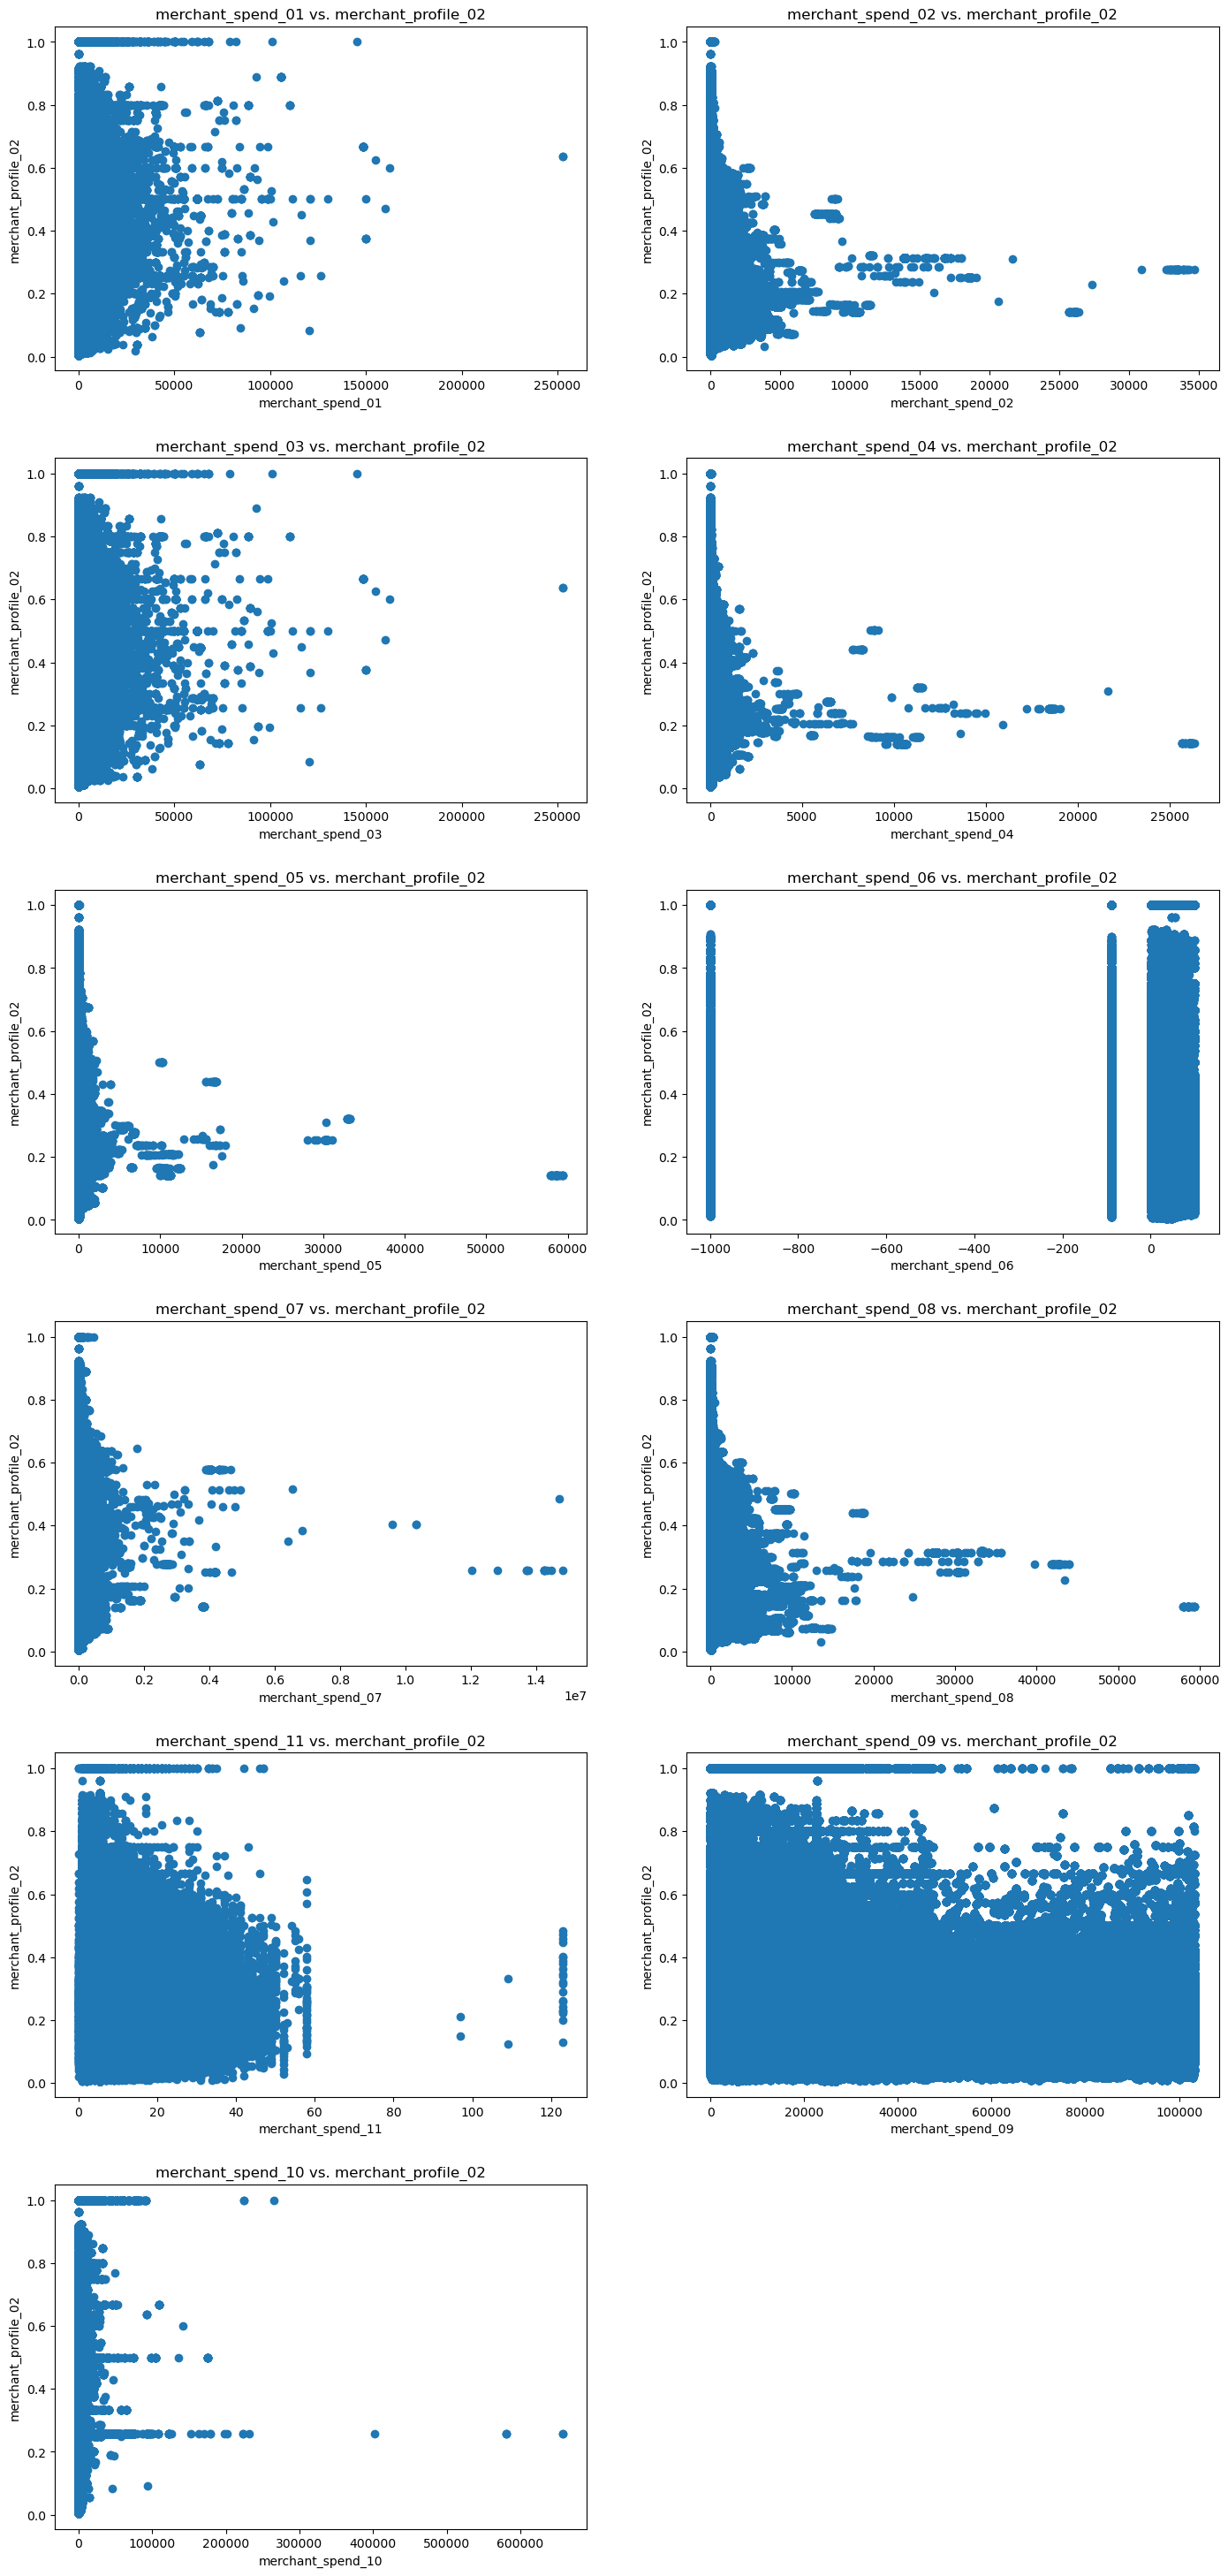

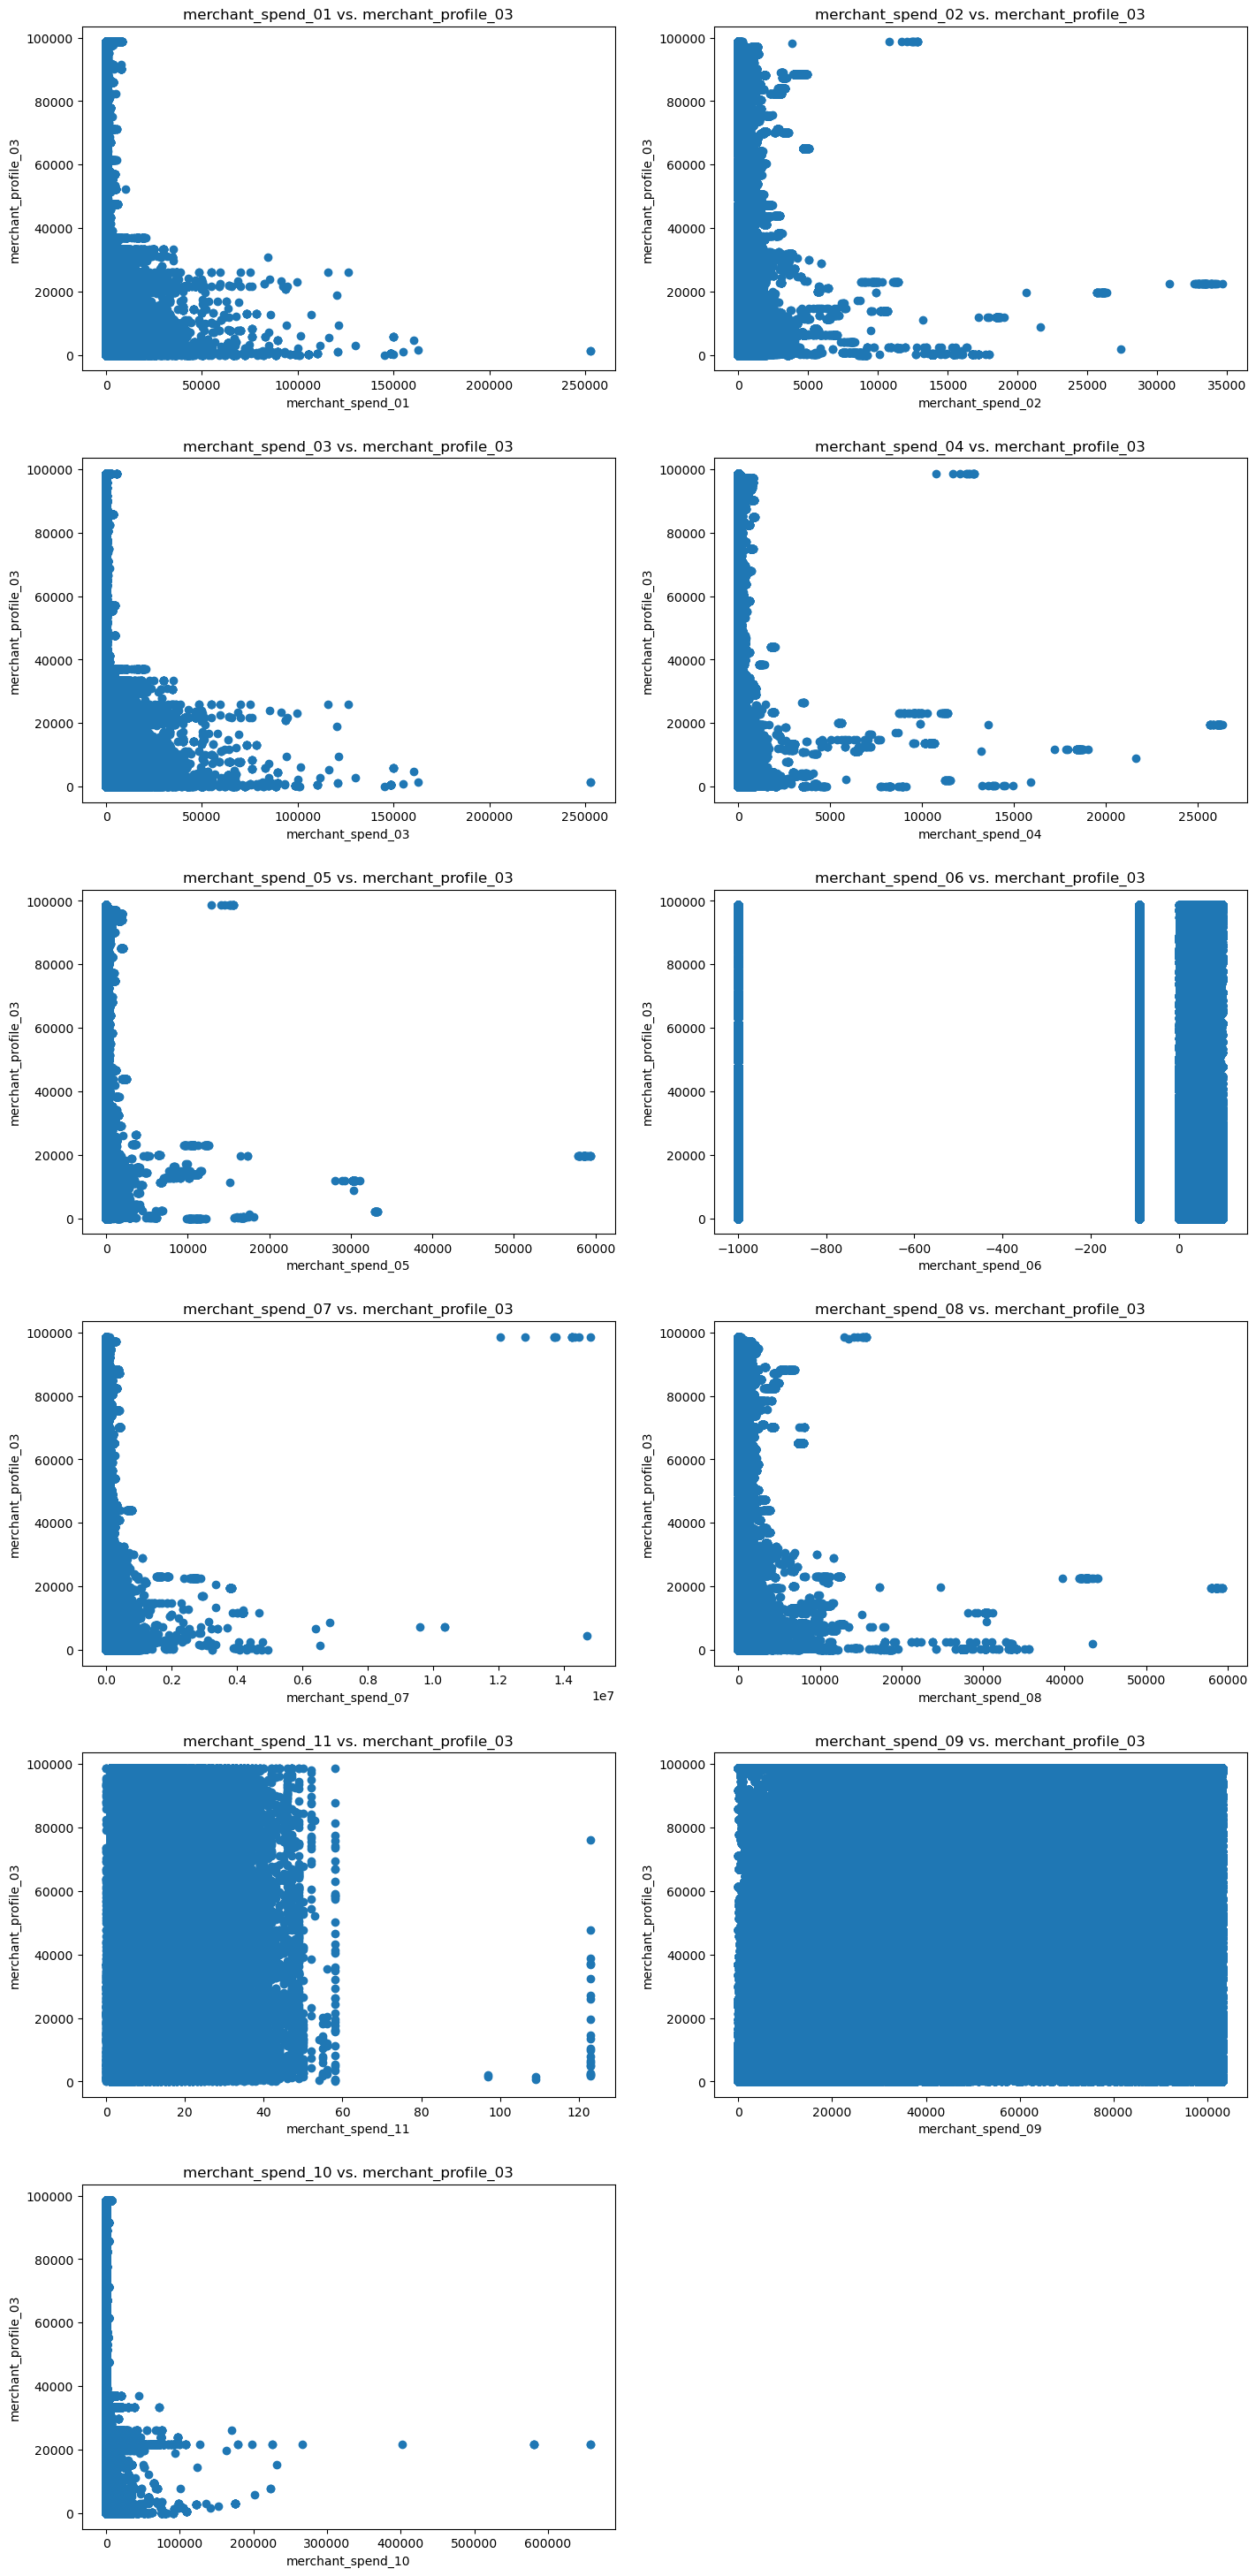

In [ ]:
display_profile_graph("merchant_profile_01")
display_profile_graph("merchant_profile_02")
display_profile_graph("merchant_profile_03")

#### As profile1 has discrete values, we want to categorize them

In [7]:
def assign_range(value):
    if value < 150:
        return 1
    elif 175 <= value <= 225:
        return 2
    elif 250 <= value <= 280:
        return 3
    elif 285 <= value <= 350:
        return 4
    elif 375 <= value <= 450:
        return 5
    elif value > 450:
        return 6

In [44]:
df_merchant['merchant_profile_01_discrete'] = df_merchant['merchant_profile_01'].apply(assign_range)

#### Not sure if the profiles have correlation

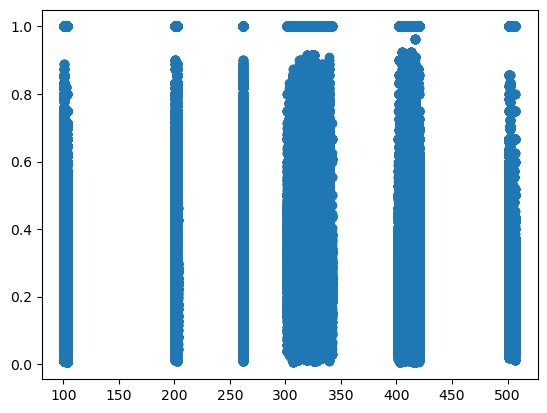

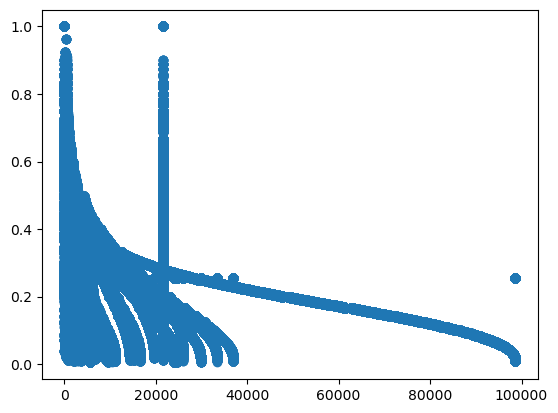

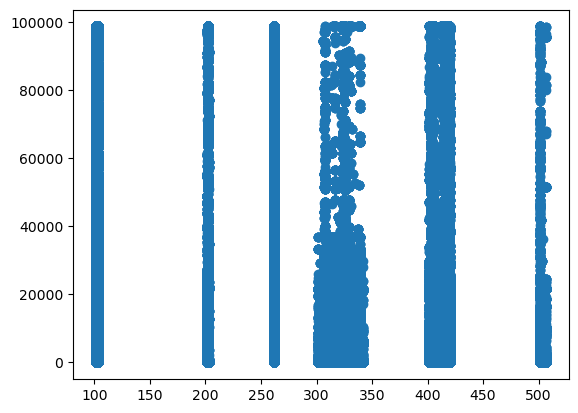

In [ ]:
plt.scatter(df_merchant['merchant_profile_01'], df_merchant['merchant_profile_02'])
plt.show()
plt.scatter(df_merchant['merchant_profile_03'], df_merchant['merchant_profile_02'])
plt.show()
plt.scatter(df_merchant['merchant_profile_01'], df_merchant['merchant_profile_03'])
plt.show()

In [56]:
def create_test_profile(target_df, merchant_profile: str):
    X = target_df.drop([merchant_profile], axis=1)  
    y = target_df[merchant_profile] 
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

## Models for continuous data

#### Random Forest

In [46]:
def run_randomForest_profile( X_train, X_test, y_train, y_test, discrete: bool):
    random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    random_forest_regressor.fit(X_train, y_train)
    y_pred = random_forest_regressor.predict(X_test)
    if not discrete:
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        print(f'Mean Squared Error: {mse}')
        print(f'Root Mean Squared Error: {rmse}')
    else: 
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix:\n{conf_matrix}")
        lb = LabelBinarizer()
        lb.fit(y_test)
        y_test_bin = lb.transform(y_test)
        y_pred_bin = lb.transform(y_pred)
        roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average="macro")
        print(f"ROC-AUC: {roc_auc}")    

#### KNN

In [73]:

def run_knn(X_train, X_test, y_train, y_test, discrete: bool):
    n = math.floor(math.sqrt(X_train.size))
    if not discrete:
        knn_model = KNeighborsRegressor(n_neighbors=5)
        knn_model.fit(X_train, y_train)
        y_pred = knn_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        print(f'Mean Squared Error: {mse}')
        print(f'Root Mean Squared Error: {rmse}')
    else:
        knn_model = KNeighborsClassifier(n_neighbors=5)
        knn_model.fit(X_train, y_train)
        y_pred = knn_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix:\n{conf_matrix}")
        lb = LabelBinarizer()
        lb.fit(y_test)
        y_test_bin = lb.transform(y_test)
        if hasattr(knn_model, "predict_proba"):
            y_pred_prob = knn_model.predict_proba(X_test)
            roc_auc = roc_auc_score(y_test_bin, y_pred_prob, average="macro", multi_class="ovr")
        else:
            y_pred_bin = lb.transform(y_pred)  # This might not be necessary for KNN
            roc_auc = "ROC AUC cannot be calculated without probability predictions for multi-class"
        
        print(f"ROC AUC Score: {roc_auc}")


#### SVM

In [48]:
def run_svm(X_train, X_test, y_train, y_test, discrete: bool):
    if not discrete:
        svm_regressor = SVR()
        svm_regressor.fit(X_train, y_train)
        y_pred = svm_regressor.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        print(f'Mean Squared Error: {mse}')
        print(f'Root Mean Squared Error: {rmse}')
    else:
        svm_classifier = SVC()
        svm_classifier.fit(X_train, y_train)
        y_pred = svm_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix:\n{conf_matrix}")
        lb = LabelBinarizer()
        lb.fit(y_test)
        y_test_bin = lb.transform(y_test)
        y_pred_bin = lb.transform(y_pred)
        if hasattr(svm_classifier, "predict_proba"):
            y_score = svm_classifier.predict_proba(X_test)
            roc_auc = roc_auc_score(y_test_bin, y_score, average="macro")
        else:
            y_score = svm_classifier.decision_function(X_test)
            roc_auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
        print(f"ROC AUC Score: {roc_auc}")


#### Perceptron

In [104]:
def run_perceptron(X_train, X_test, y_train, y_test, discrete: bool):
    if not discrete:
        return
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    perceptron_model = Perceptron()
    perceptron_model.fit(X_train, y_train)
    y_pred = perceptron_model.predict(X_test)
    if not discrete:
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        print(f'Mean Squared Error: {mse}')
        print(f'Root Mean Squared Error: {rmse}')
    else: 
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix:\n{conf_matrix}")
        lb = LabelBinarizer()
        lb.fit(y_test)
        y_test_bin = lb.transform(y_test)
        y_pred_bin = lb.transform(y_pred)
        roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average="macro")

#### Logistic Regression

In [105]:
def run_logistic_regression(X_train, X_test, y_train, y_test, discrete: bool):
    if not discrete:
        return
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    logistic_regressor = LogisticRegression(max_iter=100000)
    logistic_regressor.fit(X_train, y_train)
    y_pred = logistic_regressor.predict(X_test)
    if not discrete:
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        print(f'Mean Squared Error: {mse}')
        print(f'Root Mean Squared Error: {rmse}')
    else: 
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix:\n{conf_matrix}")
        lb = LabelBinarizer()
        lb.fit(y_test)
        y_test_bin = lb.transform(y_test)
        y_pred_bin = lb.transform(y_pred)
        roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average="macro")

In [108]:
def run_model(X_train, X_test, y_train, y_test, models, discrete):
    for model in models:
        print(model)
        try:    
            model(X_train, X_test, y_train, y_test, discrete)
        except Exception as e:
            print("Failed: " , model)


In [106]:
models = [run_randomForest_profile,run_knn,run_svm,run_perceptron,run_logistic_regression]

In [99]:
df_merchant = df_merchant.head(10000)

In [109]:
X_train, X_test, y_train, y_test = create_test_profile(df_merchant, "merchant_profile_01_discrete")
run_model(X_train, X_test, y_train, y_test, models, True)

<function run_randomForest_profile at 0x17a4f2340>
Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       772
           2       1.00      1.00      1.00       110
           3       1.00      1.00      1.00        80
           4       1.00      1.00      1.00       351
           5       1.00      1.00      1.00       682
           6       1.00      1.00      1.00         5

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Confusion Matrix:
[[772   0   0   0   0   0]
 [  0 110   0   0   0   0]
 [  0   0  80   0   0   0]
 [  0   0   0 351   0   0]
 [  0   0   0   0 682   0]
 [  0   0   0   0   0   5]]
ROC-AUC: 1.0
<function run_knn at 0x179cebe20>
Accuracy: 0.9655
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       772
           2       0.93      0.94     

/Users/dylansiew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dylansiew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dylansiew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dylansiew

Accuracy: 0.993
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       772
           2       0.98      0.98      0.98       110
           3       0.93      1.00      0.96        80
           4       1.00      0.99      0.99       351
           5       0.99      1.00      1.00       682
           6       0.00      0.00      0.00         5

    accuracy                           0.99      2000
   macro avg       0.82      0.83      0.82      2000
weighted avg       0.99      0.99      0.99      2000

Confusion Matrix:
[[770   2   0   0   0   0]
 [  0 108   2   0   0   0]
 [  0   0  80   0   0   0]
 [  0   0   4 346   1   0]
 [  0   0   0   0 682   0]
 [  0   0   0   0   5   0]]


/Users/dylansiew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dylansiew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dylansiew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [110]:
X_train, X_test, y_train, y_test = create_test_profile(df_merchant,"merchant_profile_01")
run_model(X_train, X_test, y_train, y_test, models, False)

<function run_randomForest_profile at 0x17a4f2340>
Mean Squared Error: 12.685093726181094
Root Mean Squared Error: 3.561613921550326
<function run_knn at 0x179cebe20>
Mean Squared Error: 443.19878099402644
Root Mean Squared Error: 21.052286835259167
<function run_svm at 0x17a4f0040>
Mean Squared Error: 1290.7259219982316
Root Mean Squared Error: 35.9266742407119
<function run_perceptron at 0x17985e3e0>
<function run_logistic_regression at 0x17985cb80>


In [111]:
X_train, X_test, y_train, y_test = create_test_profile(df_merchant,"merchant_profile_02")
run_model(X_train, X_test, y_train, y_test, models, False)

<function run_randomForest_profile at 0x17a4f2340>
Mean Squared Error: 0.005219984559713907
Root Mean Squared Error: 0.07224946061884412
<function run_knn at 0x179cebe20>
Mean Squared Error: 0.010212512989568535
Root Mean Squared Error: 0.1010569789255969
<function run_svm at 0x17a4f0040>
Mean Squared Error: 0.010422678338133068
Root Mean Squared Error: 0.10209151942317769
<function run_perceptron at 0x17985e3e0>
<function run_logistic_regression at 0x17985cb80>


In [112]:
X_train, X_test, y_train, y_test = create_test_profile(df_merchant,"merchant_profile_03")
run_model(X_train, X_test, y_train, y_test, models, False)

<function run_randomForest_profile at 0x17a4f2340>
Mean Squared Error: 18471161.619047478
Root Mean Squared Error: 4297.808932356984
<function run_knn at 0x179cebe20>
Mean Squared Error: 86286880.50606193
Root Mean Squared Error: 9289.073177990467
<function run_svm at 0x17a4f0040>
Mean Squared Error: 636469519.1113929
Root Mean Squared Error: 25228.34753033565
<function run_perceptron at 0x17985e3e0>
<function run_logistic_regression at 0x17985cb80>
